In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

This tutorial was created based on: https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py

In [2]:
# First of all, import the dataset
from sklearn import datasets

X_digits, y_digits = datasets.load_digits(return_X_y=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, test_size=0.33, random_state=42)

print(X_digits.shape)

(1797, 64)


In [3]:
# We want to process the dataset in two steps, containing a PCA truncation and a classifier regularization
# input ---> PCA ---> LogisticRegression ---> output 

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


In [4]:
# Naive way to do this:
# Seems simple in the beginning, becomes quite messy after some transformations
# So please, don't do this when there is a better way

# First, transform the input using PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

# Then, fit a logistic regression for the transformed X and y
logistic = LogisticRegression(max_iter=10000, tol=0.1) # note: max_iter is low, tolerance is high: just to make the example faster
logistic.fit(X_train_pca, y_train)

# Make a prediction and evaluate the model on the training set
y_train_pred = logistic.predict(X_train_pca)

# To predict for the test set, we need to transform the X_test first
X_test_pca = pca.transform(X_test) # note: we must not fit for pca for X_test!

# Then, we have to use the regression for prediction and evaluate on the test set (again: no fit for X_test!)
y_test_pred = logistic.predict(X_test_pca)

# Well, not that complicated. But try doing a grid search seeking the best parameter combinations for PCA and LogisticRegression.
# Even better, chain together multiple steps and do the same...
# We would like to handle chaining the processing steps together, so that we have one big fit() and predict() function sending the data through all of them


In [5]:
# Smart solution: pipelines
# Lets define a pipeline, chaining the steps together, so this:
# input ---> PCA ---> LogisticRegression ---> output
# can become this:
# input ---> Pipeline ---> output
# where pipeline executes the above steps

from sklearn.pipeline import Pipeline

pca = PCA(n_components=2)
logistic = LogisticRegression(max_iter=10000, tol=0.1)

pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)]) # all steps must have a name and an object doing that step
pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [6]:
# Grid search using pipelines
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pca = PCA()
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64],
    'logistic__C': np.logspace(-4, 4, 4),
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.920):
{'logistic__C': 0.046415888336127774, 'pca__n_components': 45}


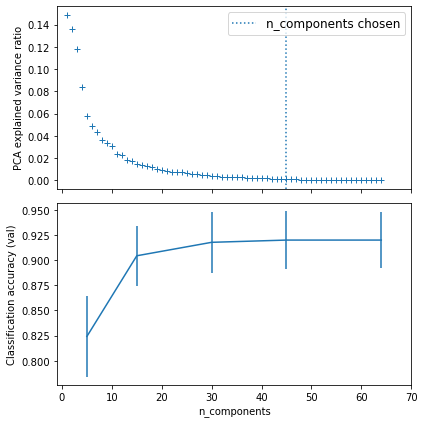

In [7]:
# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()